In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [2]:
#testing parallel run of shorter simulations for Gershman 2012's model, p is the number of simulations to run in parallel

In [3]:
def p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p):
    #index: the index of the weight to be sampled, tuple (i,j)
    #var_1: right mode; var_0: left mode
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_s = (b[:,i,j]-s_n)**2
    w_extended = np.concatenate((w[:,:,0].reshape(p,-1,1),w,w[:,:,-1].reshape(p,-1,1)),axis=2)
    w_extended = np.concatenate((w_extended[:,0,:].reshape(p,1,-1),w_extended,w_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j])**2)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i+2,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j+2])**2)
    E_x = 1/(2*var_l)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2+1/(2*var_r)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    return np.exp(-tau*(E_x+E_s))

In [4]:
def p_pi_l_new(index,w,x_l,x_r,pi_l,var_l,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xl = 1/(2*var_l)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_l[:,:,0].reshape(p,-1,1),pi_l,pi_l[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_l = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xl+E_pi_l))

In [5]:
def p_pi_r_new(index,w,x_l,x_r,pi_r,var_r,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xr = 1/(2*var_r)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_r[:,:,0].reshape(p,-1,1),pi_r,pi_r[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_r = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_r = E_pi_r + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xr+E_pi_r))

In [6]:
def proposal_function_new(z, index, p, sigma = 1):
    #generate a new proposal from the current sample
    #change only one element at a time!
    z_star = z.copy()
    i,j = index[0],index[1]
    z_star[:,i,j] = z_star[:,i,j] + sigma*random.normal(size = (p))
    return z_star

In [7]:
def binary_proposal_new(z,index):
    #p: the probability of switch, to stablize the system
    z_star = z.copy()
    z_star[:,index[0],index[1]] = 1-z[:,index[0],index[1]]
    return z_star

In [8]:
def sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p):
    p_w_cur = p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
    p_w_star = p_w_new(index,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
    p_acc = p_w_star/p_w_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var_l,b,tau,gamma,p):
    p_pi_l_cur = p_pi_l_new(index,w,x_l,x_r,pi_l,var_l,b,tau,gamma,p)
    p_pi_l_star = p_pi_l_new(index,w,x_l,x_r,pi_l_star,var_l,b,tau,gamma,p)
    p_acc = p_pi_l_star/p_pi_l_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var_r,b,tau,gamma,p):
    p_pi_r_cur = p_pi_r_new(index,w,x_l,x_r,pi_r,var_r,b,tau,gamma,p)
    p_pi_r_star = p_pi_r_new(index,w,x_l,x_r,pi_r_star,var_r,b,tau,gamma,p)
    p_acc = p_pi_r_star/p_pi_r_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

In [11]:
def simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample):
    #p: no. parallel sampling sequences
    #no. sample: no. samples in each sequence
    #dim: dimension of each MRF
    sampling_order_i = np.arange(dim)
    sampling_order_j = np.arange(dim)

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones((p,dim,dim))
    x_r = np.zeros((p,dim,dim))
    w = random.rand(p,dim,dim)
    pi_l = random.randint(0,2,(p,dim,dim))
    pi_r = random.randint(0,2,(p,dim,dim))

    s = []
    for m in range(int(no_sample)):
        #order of sweep is randomnized
        random.shuffle(sampling_order_i)
        random.shuffle(sampling_order_j)
        #the following for loop update on pi_r
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_r_star = binary_proposal_new(pi_r, index)
                acc_1 = sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var_r,b,tau,gamma,p)
                for j in range(p):
                    if acc_1[j] == 1:
                        pi_r[j,:,:] = pi_r_star[j,:,:]

        #the following for loop update on pi_l
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_l_star = binary_proposal_new(pi_l, index)
                acc_2 = sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var_l,b,tau,gamma,p)
                for j in range(p):
                    if acc_2[j] == 1:
                        pi_l[j,:,:] = pi_l_star[j,:,:]
    
            #the following for loop update on w
            for i in sampling_order_i:
                for j in sampling_order_j:
                    index = (i,j)
                    w_star = proposal_function_new(w, index, p)
                    acc_3 = sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
                    for j in range(p):
                        if acc_3[j] == 1:
                            w[j,:,:] = w_star[j,:,:]
        
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
    return np.array(s)

In [12]:
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_0005_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.004,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_0004_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.003,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_0003_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.002,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_0002_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.001,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_0001_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00075,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_000075_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_00005_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00025,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_000025_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00015,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_000015_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0001,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_00001_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

done
done
done
done
done
done
done
done
done


In [13]:
#from node's state to the no. node > 0.5 in each step
def node_count(s,p,no_sample):
    state_no_array = []
    for i in range(p):
        state_no_array_i = []
        for j in range(no_sample):
            state_no_array_i.append(len(np.where(s[j,i,:,:]>0.5)[0]))
        state_no_array.append(state_no_array_i)
    state_no_array = np.array(state_no_array)
    return state_no_array

In [14]:
def domi_period_count(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>dim**2*0.1 and state_list_input[i]<dim**2*0.1:
            cross_list.append((i,2))
        elif state_list_input[i-1]<dim**2*0.9 and state_list_input[i]>dim**2*0.9:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return domi_list

def hist_plot(x,n):
    plt.hist(x,n)
    return np.mean(x),np.std(x)

def generate_domi_list(state_count,dim):
    domi_list = []
    for state_list_i in state_count:
        domi_list_i = domi_period_count(state_list_i,dim)
        domi_list = domi_list + domi_list_i
    return domi_list

In [15]:
ave_0005_0001 = np.mean(np.array(generate_domi_list(node_count(s_0005_0001,p,no_sample),dim)))

ave_0004_0001 = np.mean(np.array(generate_domi_list(node_count(s_0004_0001,p,no_sample),dim)))

ave_0003_0001 = np.mean(np.array(generate_domi_list(node_count(s_0003_0001,p,no_sample),dim)))

ave_0002_0001 = np.mean(np.array(generate_domi_list(node_count(s_0002_0001,p,no_sample),dim)))

ave_0001_0001 = np.mean(np.array(generate_domi_list(node_count(s_0001_0001,p,no_sample),dim)))

ave_000075_0001 = np.mean(np.array(generate_domi_list(node_count(s_000075_0001,p,no_sample),dim)))

ave_00005_0001 = np.mean(np.array(generate_domi_list(node_count(s_00005_0001,p,no_sample),dim)))

ave_000025_0001 = np.mean(np.array(generate_domi_list(node_count(s_000025_0001,p,no_sample),dim)))

ave_000015_0001 = np.mean(np.array(generate_domi_list(node_count(s_000015_0001,p,no_sample),dim)))

ave_00001_0001 = np.mean(np.array(generate_domi_list(node_count(s_00001_0001,p,no_sample),dim)))

In [16]:
print(ave_0005_0001)
print(ave_0004_0001)
print(ave_0003_0001)
print(ave_0002_0001)
print(ave_0001_0001)
print(ave_000075_0001)
print(ave_00005_0001)
print(ave_000025_0001)
print(ave_000015_0001)
print(ave_00001_0001)

570.29375525063
575.2022695035461
502.3507260644844
423.2995694074226
328.4507392996109
309.5382128159906
290.3215707812715
288.30039579636957
293.25638888888886
291.12189054726366


In [17]:
ave_array_1 = np.array([ave_0005_0001,ave_0004_0001,ave_0003_0001,ave_0002_0001,ave_0001_0001])
ave_array_2 = np.array([ave_00005_0001,ave_000025_0001,ave_000015_0001,ave_00001_0001])

In [18]:
diff_cont_1 = np.array([(1/0.001-1/0.005),(1/0.001-1/0.004),(1/0.001-1/0.003),(1/0.001-1/0.002),0])
diff_cont_2 = np.array([(1/0.0005-1/0.001),(1/0.00025-1/0.001),(1/0.00015-1/0.001),(1/0.0001-1/0.001)])

Text(0, 0.5, 'mean dominance duration')

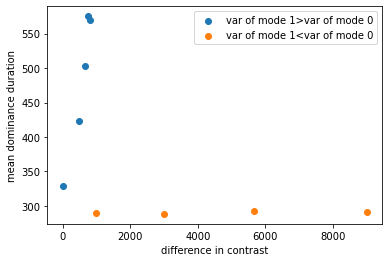

In [19]:
plt.scatter(diff_cont_1,ave_array_1)
plt.scatter(diff_cont_2,ave_array_2)
plt.legend(['var of mode 1>var of mode 0','var of mode 1<var of mode 0'])
plt.xlabel('difference in contrast')
plt.ylabel('mean dominance duration')

In [20]:
def domi_period_count_new(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>0.1*dim**2 and state_list_input[i]<0.1*dim**2:
            cross_list.append((i,2))
        elif state_list_input[i-1]<0.9*dim**2 and state_list_input[i]>0.9*dim**2:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    percept_list = []
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
        percept_list.append(switch_list[i-1][1])
    return domi_list,percept_list

def generate_domi_percept_list(state_count,dim):
    domi_list = []
    percept_list = []
    for state_list_i in state_count:
        domi_list_i,percept_list_i = domi_period_count_new(state_list_i,dim)
        domi_list = domi_list + domi_list_i
        percept_list = percept_list+percept_list_i
    return domi_list,percept_list

In [21]:
domi_list_0005_0001,percept_list_0005_0001 = generate_domi_percept_list(node_count(s_0005_0001,p,no_sample),dim)
domi_list_0004_0001,percept_list_0004_0001 = generate_domi_percept_list(node_count(s_0004_0001,p,no_sample),dim)
domi_list_0003_0001,percept_list_0003_0001 = generate_domi_percept_list(node_count(s_0003_0001,p,no_sample),dim)
domi_list_0002_0001,percept_list_0002_0001 = generate_domi_percept_list(node_count(s_0002_0001,p,no_sample),dim)
domi_list_0001_0001,percept_list_0001_0001 = generate_domi_percept_list(node_count(s_0001_0001,p,no_sample),dim)
domi_list_000075_0001,percept_list_000075_0001 = generate_domi_percept_list(node_count(s_000075_0001,p,no_sample),dim)
domi_list_00005_0001,percept_list_00005_0001 = generate_domi_percept_list(node_count(s_00005_0001,p,no_sample),dim)
domi_list_000025_0001,percept_list_000025_0001 = generate_domi_percept_list(node_count(s_000025_0001,p,no_sample),dim)
domi_list_000015_0001,percept_list_000015_0001 = generate_domi_percept_list(node_count(s_000015_0001,p,no_sample),dim)
domi_list_00001_0001,percept_list_00001_0001 = generate_domi_percept_list(node_count(s_00001_0001,p,no_sample),dim)

In [22]:
def predomi_count(domi_period,domi_percept):
    domi_1 = 0
    domi_2 = 0
    for i in range(len(domi_period)):
        if domi_percept[i] == 1:
            domi_1 = domi_1 + domi_period[i]
        else:
            domi_2 = domi_2 + domi_period[i]
    return domi_1/np.sum(domi_period),domi_2/np.sum(domi_period)

def ave_domi_count(domi_period,domi_percept):
    domi_1_t = 0
    domi_2_t = 0
    domi_1_count = 0
    domi_2_count = 0
    for i in range(len(domi_period)):
        if int(domi_percept[i]) == 1:
            domi_1_t = domi_1_t + domi_period[i]
            domi_1_count = domi_1_count +1
        else:
            domi_2_t = domi_2_t + domi_period[i]
            domi_2_count = domi_2_count +1
    return domi_1_t/domi_1_count, domi_2_t/domi_2_count

In [23]:
predomi_list = [predomi_count(domi_list_0005_0001,percept_list_0005_0001)[0]]
predomi_list.append(predomi_count(domi_list_0004_0001,percept_list_0004_0001)[0])
predomi_list.append(predomi_count(domi_list_0003_0001,percept_list_0003_0001)[0])
predomi_list.append(predomi_count(domi_list_0002_0001,percept_list_0002_0001)[0])
predomi_list.append(predomi_count(domi_list_0001_0001,percept_list_0001_0001)[0])
predomi_list.append(predomi_count(domi_list_000075_0001,percept_list_000075_0001)[0])
predomi_list.append(predomi_count(domi_list_00005_0001,percept_list_00005_0001)[0])
predomi_list.append(predomi_count(domi_list_000025_0001,percept_list_000025_0001)[0])
predomi_list.append(predomi_count(domi_list_000015_0001,percept_list_000015_0001)[0])
predomi_list.append(predomi_count(domi_list_00001_0001,percept_list_00001_0001)[0])

In [24]:
contrast_array = np.array([1/0.005,1/0.004,1/0.003,1/0.002,1/0.001,1/0.00075,1/0.0005,1/0.00025,1/0.00015,1/0.0001])

Text(0, 0.5, 'predominance of mode 1')

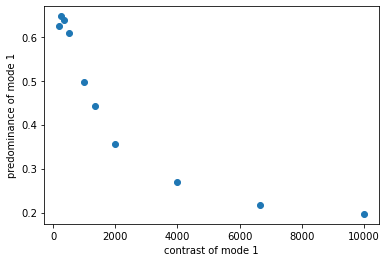

In [25]:
plt.scatter(contrast_array,np.array(predomi_list))
plt.xlabel('contrast of mode 1')
plt.ylabel('predominance of mode 1')

In [26]:
ave_domi_1 = []
ave_domi_2 = []
ave_0001_0005 = ave_domi_count(domi_list_0005_0001,percept_list_0005_0001)
ave_domi_1.append(ave_0001_0005[0])
ave_domi_2.append(ave_0001_0005[1])
ave_0001_0004 = ave_domi_count(domi_list_0004_0001,percept_list_0004_0001)
ave_domi_1.append(ave_0001_0004[0])
ave_domi_2.append(ave_0001_0004[1])
ave_0001_0003 = ave_domi_count(domi_list_0003_0001,percept_list_0003_0001)
ave_domi_1.append(ave_0001_0003[0])
ave_domi_2.append(ave_0001_0003[1])
ave_0001_0002 = ave_domi_count(domi_list_0002_0001,percept_list_0002_0001)
ave_domi_1.append(ave_0001_0002[0])
ave_domi_2.append(ave_0001_0002[1])
ave_0001_0001 = ave_domi_count(domi_list_0001_0001,percept_list_0001_0001)
ave_domi_1.append(ave_0001_0001[0])
ave_domi_2.append(ave_0001_0001[1])
ave_0001_000075 = ave_domi_count(domi_list_000075_0001,percept_list_000075_0001)
ave_domi_1.append(ave_0001_000075[0])
ave_domi_2.append(ave_0001_000075[1])
ave_0001_00005 = ave_domi_count(domi_list_00005_0001,percept_list_00005_0001)
ave_domi_1.append(ave_0001_00005[0])
ave_domi_2.append(ave_0001_00005[1])
ave_0001_000025 = ave_domi_count(domi_list_000025_0001,percept_list_000025_0001)
ave_domi_1.append(ave_0001_000025[0])
ave_domi_2.append(ave_0001_000025[1])
ave_0001_000015 = ave_domi_count(domi_list_000015_0001,percept_list_000015_0001)
ave_domi_1.append(ave_0001_000015[0])
ave_domi_2.append(ave_0001_000015[1])
ave_0001_00001 = ave_domi_count(domi_list_00001_0001,percept_list_00001_0001)
ave_domi_1.append(ave_0001_00001[0])
ave_domi_2.append(ave_0001_00001[1])

Text(0, 0.5, 'mean dominance duration')

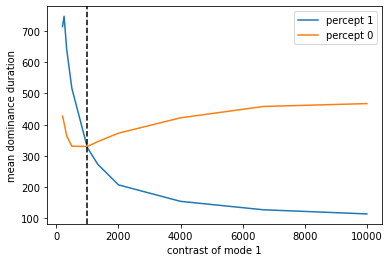

In [27]:
plt.plot(contrast_array,np.array(ave_domi_1))
plt.plot(contrast_array,np.array(ave_domi_2))
plt.legend(['percept 1', 'percept 0'])
plt.axvline(x = 1000, linestyle='dashed', color = 'k')
plt.xlabel('contrast of mode 1')
plt.ylabel('mean dominance duration')

In [28]:
print(ave_domi_1)
print(ave_domi_2)
print(326.3339540657976-116.93103448275862)
print(327.86583850931675-481.16259931895576)

[713.6341189674523, 746.6793849658314, 640.4913920314806, 516.1242287124641, 326.583644278607, 273.45873715124816, 207.53177441540578, 154.81637107776262, 127.884561891516, 114.64546460176992]
[427.5142537730576, 404.98530243075186, 364.0059113300493, 331.04415372035976, 330.3219071361795, 345.6813768755516, 372.81633771929825, 421.89377389404694, 458.1694868238558, 467.4033149171271]
209.40291958303902
-153.296760809639


Text(0.5, 0, 'state of single node')

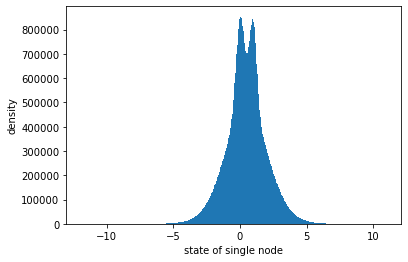

In [29]:
plt.hist(s_000075_0001.reshape(-1),500)
plt.ylabel('density')
plt.xlabel('state of single node')

In [98]:
var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.005,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_0005_0005 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0025,0.0025,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_00025_00025 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')


var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00075,0.00075,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_000075_000075 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,0.0005,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_00005_00005 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00025,0.00025,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_000025_000025 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0001,0.0001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_00001_00001 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)

done
done
done
done
done


In [99]:
domi_list_0005_0005 = np.array(generate_domi_list(node_count(s_0005_0005,p,no_sample),dim))
ave_0005_0005 = np.mean(domi_list_0005_0005)

domi_list_00025_00025 = np.array(generate_domi_list(node_count(s_00025_00025,p,no_sample),dim))
ave_00025_00025 = np.mean(domi_list_00025_00025)

domi_list_000075_000075 = np.array(generate_domi_list(node_count(s_000075_000075,p,no_sample),dim))
ave_000075_000075 = np.mean(domi_list_000075_000075)

domi_list_00005_00005 = np.array(generate_domi_list(node_count(s_00005_00005,p,no_sample),dim))
ave_00005_00005 = np.mean(domi_list_00005_00005)

domi_list_000025_000025 = np.array(generate_domi_list(node_count(s_000025_000025,p,no_sample),dim))
ave_000025_000025 = np.mean(domi_list_000025_000025)

domi_list_00001_00001 = np.array(generate_domi_list(node_count(s_00001_00001,p,no_sample),dim))
ave_00001_00001 = np.mean(domi_list_00001_00001)

Text(0, 0.5, 'mean dominance duration')

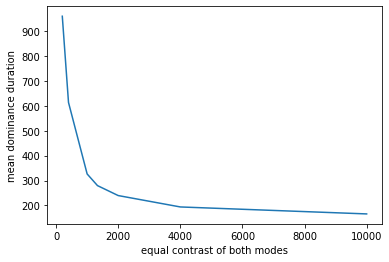

In [104]:
arr_x = np.array([1/0.005,1/0.0025,1/0.001,1/0.00075,1/0.0005,1/0.00025,1/0.0001])
arr_y = np.array([ave_0005_0005,ave_00025_00025,ave_0001_0001[0],ave_000075_000075,ave_00005_00005,ave_000025_000025,ave_00001_00001])
plt.plot(arr_x,arr_y)
plt.xlabel('equal contrast of both modes')
plt.ylabel('mean dominance duration')